# Multi-Representation Indexing

What is multi-representation indexing?
Multi-representation indexing involves creating and storing multiple representations of each document within the retrieval system. These representations can be derived from different techniques, such as:

Textual analysis: Extracting keywords, named entities, or using topic modeling algorithms.

Semantic embeddings: Utilizing pre-trained LLMs to capture the semantic meaning of the text.

Visual features: Processing images or diagrams associated with the document.

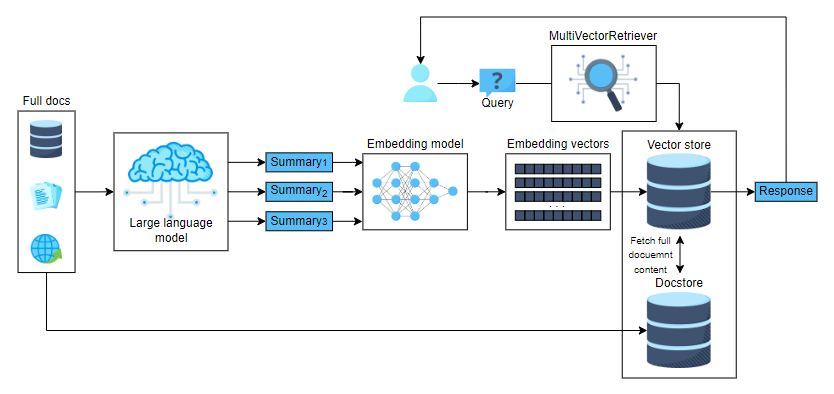

# Import Necessary Libraries



In [2]:
! pip install langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.7/408.7 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.5 MB/s eta 0:00:00
  Attempting uninstall: SQLAlchemy
    Found existing installation: SQLAlchemy 2.0.36
    Uninstalling SQLAlchemy-2.0.36:
      Successfully uninstalled SQLAlchemy-2.0.36
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.13
    Uninstalling langchain-core-0.3.13:
      Successfully uninstalled langchain-core-0.3.13
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.4
    Uninstalling langchain-0.3.4:
      Successfully uninstalled langchain-0.3.4


In [4]:
! pip install langchain_openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.7 MB/s eta 0:00:00


In [8]:
! pip install pypdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 4.9 MB/s eta 0:00:00


In [12]:
! pip install chromadb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.7/615.7 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.8/273.8 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.7/94.7 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.7/149.7 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 5.3 MB/s eta 0:00:

In [45]:
! pip install langchain_chroma

# Import necessary libraries

In [50]:
import os
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain.storage import InMemoryByteStore
from langchain.retrievers.multi_vector import MultiVectorRetriever
import uuid
from langchain_core.documents import Document

# Set up the OpenAI API key

In [76]:
OPENAI_API_KEY = os.environ["OPENAI_API_KEY"] = ""  # Add your OpenAI API key
if OPENAI_API_KEY == "":
    raise ValueError("Please set the OPENAI_API_KEY environment variable")

# Load documents and split text

In [55]:
loaders = [
    PyPDFLoader("Attention_is_all_you_need.pdf"),
    PyPDFLoader("Comparativestudyofwordembeddingalgorithm.pdf")
]

docs = []
for loader in loaders:
    docs.extend(loader.load())

text_splitter = RecursiveCharacterTextSplitter(chunk_size=10000)
docs = text_splitter.split_documents(docs)

In [57]:
len(docs)

27

In [63]:
docs[0]

Document(metadata={'source': 'Attention_is_all_you_need.pdf', 'page': 0}, page_content='Provided proper attribution is provided, Google hereby grants permission to\nreproduce the tables and figures in this paper solely for use in journalistic or\nscholarly works.\nAttention Is All You Need\nAshish Vaswani∗\nGoogle Brain\navaswani@google.com\nNoam Shazeer∗\nGoogle Brain\nnoam@google.com\nNiki Parmar∗\nGoogle Research\nnikip@google.com\nJakob Uszkoreit∗\nGoogle Research\nusz@google.com\nLlion Jones∗\nGoogle Research\nllion@google.com\nAidan N. Gomez∗ †\nUniversity of Toronto\naidan@cs.toronto.edu\nŁukasz Kaiser∗\nGoogle Brain\nlukaszkaiser@google.com\nIllia Polosukhin∗ ‡\nillia.polosukhin@gmail.com\nAbstract\nThe dominant sequence transduction models are based on complex recurrent or\nconvolutional neural networks that include an encoder and a decoder. The best\nperforming models also connect the encoder and decoder through an attention\nmechanism. We propose a new simple network archite

In [64]:
docs[26]

Document(metadata={'source': 'Comparativestudyofwordembeddingalgorithm.pdf', 'page': 9}, page_content='Marwa Naili et al. / Procedia Computer Science 112 (2017) 340–349 349\nIf we compare our results with related works, some statements can be doubted. For example, Pennington et\nal. 2 argue that GloVe performs better than Word2Vec in every task (word analogies, word similarity and named\nentity recognition). Even Mitra 4 proved the same results. Yet, we share the same statement of Mikolov et al. 1 that\nWord2Vec outperforms other models. Yet, the performance of GloVe is comparable to Word2Vec and they can be\nconsidered as two powerful methods to learn word vector representations in the domain of topic segmentation. On the\nother hand, if we compare modern prediction-based embeddings (Word2Vec and GloVe) with traditional count-based\nmethods (LSA), we share the same claim as Baroni et al. 6 that LSA is less eﬃcient than the other models for synonym\ndetection, concept categorization, s

# Generate document summaries with LLM

In [78]:
chain = (
    {"doc": lambda x: x.page_content}
    | ChatPromptTemplate.from_template("Summarize the following document:\n\n{doc}")
    | ChatOpenAI(model="gpt-4o-mini", max_retries=0)
    | StrOutputParser()
)


In [74]:
chain

{
  doc: RunnableLambda(lambda x: x.page_content)
}
| ChatPromptTemplate(input_variables=['doc'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['doc'], input_types={}, partial_variables={}, template='Summarize the following document:\n\n{doc}'), additional_kwargs={})])
| ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x78b58c1288b0>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x78b5929462f0>, root_client=<openai.OpenAI object at 0x78b58c12a3e0>, root_async_client=<openai.AsyncOpenAI object at 0x78b58c128820>, model_name='gpt-4o-mini', model_kwargs={}, openai_api_key=SecretStr(''), max_retries=0)
| StrOutputParser()

In [79]:
summaries = chain.batch(docs, {"max_concurrency": 3})

In [80]:
len(summaries)

27

In [82]:
summaries[0]

'The document outlines a research paper titled "Attention Is All You Need," authored by a team from Google Brain and Google Research, which introduces a novel neural network architecture called the Transformer. This architecture solely relies on attention mechanisms, eliminating the need for complex recurrent or convolutional networks typical in previous sequence transduction models. The authors demonstrate that the Transformer model outperforms existing models in machine translation tasks, achieving state-of-the-art BLEU scores of 28.4 for English-to-German and 41.8 for English-to-French translations, with significantly reduced training times and costs. Additionally, the Transformer shows strong generalization capabilities, performing well in English constituency parsing tasks. The paper emphasizes the collaborative contributions of the authors, highlighting their roles in developing and evaluating the model. The work was presented at the 31st Conference on Neural Information Processi

In [84]:
docs[0].page_content

'Provided proper attribution is provided, Google hereby grants permission to\nreproduce the tables and figures in this paper solely for use in journalistic or\nscholarly works.\nAttention Is All You Need\nAshish Vaswani∗\nGoogle Brain\navaswani@google.com\nNoam Shazeer∗\nGoogle Brain\nnoam@google.com\nNiki Parmar∗\nGoogle Research\nnikip@google.com\nJakob Uszkoreit∗\nGoogle Research\nusz@google.com\nLlion Jones∗\nGoogle Research\nllion@google.com\nAidan N. Gomez∗ †\nUniversity of Toronto\naidan@cs.toronto.edu\nŁukasz Kaiser∗\nGoogle Brain\nlukaszkaiser@google.com\nIllia Polosukhin∗ ‡\nillia.polosukhin@gmail.com\nAbstract\nThe dominant sequence transduction models are based on complex recurrent or\nconvolutional neural networks that include an encoder and a decoder. The best\nperforming models also connect the encoder and decoder through an attention\nmechanism. We propose a new simple network architecture, the Transformer,\nbased solely on attention mechanisms, dispensing with recurren

In [85]:
summaries[26]

"The document by Marwa Naili et al. compares various word embedding methods (LSA, Word2Vec, and GloVe) in the context of topic segmentation for both English and Arabic languages. The authors note that while some studies claim GloVe consistently outperforms Word2Vec across tasks, they align with Mikolov et al. in asserting that Word2Vec is superior overall, although GloVe's performance is comparable. Traditional count-based methods like LSA are deemed less effective than modern predictive methods for tasks such as synonym detection and analogy, yet some studies suggest LSA performs better in specific scenarios.\n\nIn their evaluation of topic segmentation performance, the authors find that exogenous segmenters (those utilizing external knowledge) significantly outperform endogenous ones in both languages. Specifically, ToSe-Word2Vec and ToSe-GloVe emerged as the most effective segmenters, particularly highlighting Word2Vec's efficiency due to its ability to capture semantic meanings thr

In [86]:
docs[26].page_content

'Marwa Naili et al. / Procedia Computer Science 112 (2017) 340–349 349\nIf we compare our results with related works, some statements can be doubted. For example, Pennington et\nal. 2 argue that GloVe performs better than Word2Vec in every task (word analogies, word similarity and named\nentity recognition). Even Mitra 4 proved the same results. Yet, we share the same statement of Mikolov et al. 1 that\nWord2Vec outperforms other models. Yet, the performance of GloVe is comparable to Word2Vec and they can be\nconsidered as two powerful methods to learn word vector representations in the domain of topic segmentation. On the\nother hand, if we compare modern prediction-based embeddings (Word2Vec and GloVe) with traditional count-based\nmethods (LSA), we share the same claim as Baroni et al. 6 that LSA is less eﬃcient than the other models for synonym\ndetection, concept categorization, selection preferences and analogy. Yet, Levy et al. 3 argue that LSA outperforms\nWord2Vec and GloVe fo

# Index with multiple representations

In [87]:
vectorstore = Chroma(collection_name="summaries", embedding_function=OpenAIEmbeddings())

store = InMemoryByteStore()
id_key = "doc_id"

retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    byte_store=store,
    id_key=id_key,
)

doc_ids = [str(uuid.uuid4()) for _ in docs]

summary_docs = [
    Document(page_content=s, metadata={id_key: doc_ids[i]})
    for i, s in enumerate(summaries)
]

retriever.vectorstore.add_documents(summary_docs)
retriever.docstore.mset(list(zip(doc_ids, docs)))

In [100]:
query = "What is topic segmentation?"

In [101]:
sub_docs = vectorstore.similarity_search(query)

In [102]:
sub_docs[0]

Document(metadata={'doc_id': '15680797-40ba-4a4e-85fb-ae86150a9e24'}, page_content='The document discusses various methods for topic segmentation in natural language processing, focusing on three main techniques: Latent Semantic Analysis (LSA), Word2Vec, and GloVe. \n\n1. **Latent Semantic Analysis (LSA)**: The process involves constructing a term-document matrix, followed by a singular value decomposition to reduce the dimensionality of the semantic space. The authors reference an empirical study by Naili et al. that identified optimal parameters for LSA, concluding that local and global frequency settings, weight functions, and the dimensionality of the reduced space significantly affect topic segmentation quality.\n\n2. **Word2Vec**: This is a word embedding model that utilizes two architectures—Continuous Bag of Words (CBOW) and Skip-Gram. CBOW predicts a target word based on its context, while Skip-Gram predicts context words from a given target word. The document highlights the c

In [103]:
retrieved_docs = retriever.invoke(query)

In [105]:
retrieved_docs[0].page_content[0:500]

'342 Marwa Naili et al. / Procedia Computer Science 112 (2017) 340–349\nterm i in the document j. The second step is the singular value decomposition where M will be decomposed,\naccording to the equation 1, into three matrices: U , V T which are two orthogonal matrices and S which is\na diagonal matrix. Finally, based on equation 2, only the k largest singular values and their corresponding\nsingular vectors from U and V T will be used in order to reduce the semantic space which corresponds to M k.\n'

In [106]:
len(retrieved_docs[0].page_content)

8190

In [108]:
retrieved_docs[0].page_content

'342 Marwa Naili et al. / Procedia Computer Science 112 (2017) 340–349\nterm i in the document j. The second step is the singular value decomposition where M will be decomposed,\naccording to the equation 1, into three matrices: U , V T which are two orthogonal matrices and S which is\na diagonal matrix. Finally, based on equation 2, only the k largest singular values and their corresponding\nsingular vectors from U and V T will be used in order to reduce the semantic space which corresponds to M k.\nM = U ∗ S ∗ V T (1)\nM k = U k ∗ Sk ∗ V t\nk (2)\nThe LSA method is based on several parameters which are: local and global frequencies setting, local and\nglobal weighting functions and the dimension of the semantic space. Naili et al. 12 have conducted an empirical\nstudy of LSA parameters in the ﬁeld of topic segmentation. As result, they proved that these parameters have an\nimportant impact on the quality of topic segmentation. Furthermore, the best choices are: local frequency =3,\ng

In [110]:
docs[17].page_content

'Marwa Naili et al. / Procedia Computer Science 112 (2017) 340–349 341Available online at www.sciencedirect.com\nProcedia Computer Science 00 (2017) 000–000\nwww.elsevier.com/ locate /procedia\nInternational Conference on Knowledge Based and Intelligent Information and Engineering\nSystems, KES2017, 6-8 September 2017, Marseille, France\nComparative study of word embedding methods in topic\nsegmentation\nMarwa Naili ∗, Anja Habacha Chaibi, Henda Hajjami Ben Ghezala\nRIADI laboratory, National School of computer Science (ENSI),\nUniversity of Mannouba 2010, Tunisia\nAbstract\nThe vector representations of words are very useful in di ﬀerent natural language processing tasks in order to capture the semantic\nmeaning of words. In this context, the three known methods are: LSA, Word2Vec and GloVe. In this paper, these methods will\nbe investigated in the ﬁeld of topic segmentation for both languages Arabic and English. Moreover, Word2Vec is studied in depth\nby using diﬀerent models and app

In [129]:
query = "What is a Encoder ?"

In [130]:
sub_docs = vectorstore.similarity_search(query , 3)

In [131]:
sub_docs[0]

Document(metadata={'doc_id': '1c1917eb-2814-4204-ad86-821f125c1eed'}, page_content='The document introduces the Transformer model, a novel architecture in the field of sequence modeling and transduction tasks, particularly in language processing. It highlights the limitations of traditional recurrent neural networks (RNNs), including long short-term memory (LSTM) and gated recurrent networks, which rely on sequential computation and hinder parallelization, especially with longer sequences.\n\nThe Transformer model addresses these constraints by completely eliminating recurrence and utilizing an attention mechanism to capture global dependencies between input and output sequences. This design allows for significant parallelization and achieves state-of-the-art performance in translation tasks with efficient training times.\n\nThe document also discusses the background of other models like the Extended Neural GPU, ByteNet, and ConvS2S, which use convolutional neural networks to reduce se

In [132]:
retrieved_docs = retriever.invoke(query)

In [133]:
len(retrieved_docs[0].page_content)

4257

In [134]:
len(retrieved_docs[1].page_content)

818

In [135]:
len(retrieved_docs[2].page_content)

1826

In [136]:
retrieved_docs[0].page_content

'1 Introduction\nRecurrent neural networks, long short-term memory [13] and gated recurrent [7] neural networks\nin particular, have been firmly established as state of the art approaches in sequence modeling and\ntransduction problems such as language modeling and machine translation [ 35, 2, 5]. Numerous\nefforts have since continued to push the boundaries of recurrent language models and encoder-decoder\narchitectures [38, 24, 15].\nRecurrent models typically factor computation along the symbol positions of the input and output\nsequences. Aligning the positions to steps in computation time, they generate a sequence of hidden\nstates ht, as a function of the previous hidden state ht−1 and the input for position t. This inherently\nsequential nature precludes parallelization within training examples, which becomes critical at longer\nsequence lengths, as memory constraints limit batching across examples. Recent work has achieved\nsignificant improvements in computational efficiency t

In [137]:
retrieved_docs[1].page_content

'Input-Input Layer5\nThe\nLaw\nwill\nnever\nbe\nperfect\n,\nbut\nits\napplication\nshould\nbe\njust\n-\nthis\nis\nwhat\nwe\nare\nmissing\n,\nin\nmy\nopinion\n.\n<EOS>\n<pad>\nThe\nLaw\nwill\nnever\nbe\nperfect\n,\nbut\nits\napplication\nshould\nbe\njust\n-\nthis\nis\nwhat\nwe\nare\nmissing\n,\nin\nmy\nopinion\n.\n<EOS>\n<pad>\nInput-Input Layer5\nThe\nLaw\nwill\nnever\nbe\nperfect\n,\nbut\nits\napplication\nshould\nbe\njust\n-\nthis\nis\nwhat\nwe\nare\nmissing\n,\nin\nmy\nopinion\n.\n<EOS>\n<pad>\nThe\nLaw\nwill\nnever\nbe\nperfect\n,\nbut\nits\napplication\nshould\nbe\njust\n-\nthis\nis\nwhat\nwe\nare\nmissing\n,\nin\nmy\nopinion\n.\n<EOS>\n<pad>\nFigure 5: Many of the attention heads exhibit behaviour that seems related to the structure of the\nsentence. We give two such examples above, from two different heads from the encoder self-attention\nat layer 5 of 6. The heads clearly learned to perform different tasks.\n15'